# Plasticity Model

Von Mises plasticity Based on model in Numerical tours... https://comet-fenics.readthedocs.io/en/latest/demo/2D_plasticity/vonMises_plasticity.py.html

Updated for Fenics 0.8.0

In [19]:
import numpy as np

import dolfinx

from mpi4py import MPI
from petsc4py import PETSc

from dolfinx import fem, mesh, io, plot, log, default_scalar_type
from dolfinx.fem import Constant, dirichletbc, Function, functionspace, Expression
from dolfinx.fem.petsc import NonlinearProblem, LinearProblem
from dolfinx.nls.petsc import NewtonSolver
from dolfinx.io.gmshio import model_to_mesh
import ufl
from ufl import (
    TestFunctions,
    TrialFunction,
    Identity,
    grad,
    det,
    div,
    dev,
    inv,
    tr,
    sqrt,
    conditional,
    gt,
    dx,
    inner,
    derivative,
    dot,
    ln,
    split,
    TestFunction,
    indices,
    as_tensor,
    as_vector
)

from basix.ufl import element, mixed_element, quadrature_element
from datetime import datetime
from dolfinx.plot import vtk_mesh
from dolfinx.io import VTXWriter


import pyvista

pyvista.set_jupyter_backend("client")
## Define temporal parameters

In [20]:
import gmsh

gmsh.initialize()
gmsh.open("meshes/thick_cylinder.geo")
gmsh.model.mesh.generate(2)
gmsh.model.mesh.optimize("Netgen")
domain, ct, ft = model_to_mesh(gmsh.model, MPI.COMM_WORLD, 0, gdim=2)
gmsh.finalize()

Info    : Reading 'meshes/thick_cylinder.geo'...
Info    : Done reading 'meshes/thick_cylinder.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Circle)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Circle)
Info    : Done meshing 1D (Wall 0.000275542s, CPU 0.000372s)
Info    : Meshing 2D...
Info    : Meshing surface 6 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0108835s, CPU 0.011182s)
Info    : 812 nodes 1625 elements
Info    : Optimizing mesh (Netgen)...
Info    : Done optimizing mesh (Wall 1.24998e-06s, CPU 4e-06s)


In [21]:
plotter = pyvista.Plotter()
vtkdata = vtk_mesh(domain, domain.topology.dim)
grid = pyvista.UnstructuredGrid(*vtkdata)
actor = plotter.add_mesh(grid, show_edges=True)
plotter.show()
plotter.close()

Widget(value="<iframe src='http://localhost:42863/index.html?ui=P_0xffff509b14b0_0&reconnect=auto' style='widt…

In [22]:
E = Constant(domain, 70e3)
nu = Constant(domain, 0.3)
lmbda = E * nu / (1 + nu) / (1 - 2 * nu)
mu = E / 2.0 / (1 + nu)
sig0 = Constant(domain, 250.0)  # yield strength
Et = E / 100.0  # tangent modulus
H = E * Et / (E - Et)  # hardening modulus

Re, Ri = 1.3, 1.0  # external/internal radius


ds = ufl.Measure("ds", domain=domain, subdomain_data=ft)

In [27]:
E_val = E.value

H_val = E_val*E_val/100 /(E_val-E_val/100)

H_val

707.070707070707

# Function Spaces

In [5]:
deg_u = 2
deg_stress = 2
U_Ele = element(
    "Lagrange", domain.basix_cell(), deg_u, shape=(2,)
)  # 2 degreeso of freedom
V = functionspace(domain, U_Ele)

We = quadrature_element(domain.basix_cell(), value_shape=(4,), degree=deg_stress)
W = functionspace(domain, We)

W0e = quadrature_element(domain.basix_cell(), degree=deg_stress)
W0 = functionspace(domain, W0e)

In [6]:
sig = Function(W)
sig_old = Function(W)
n_elas = Function(W)
beta = Function(W0)
p = Function(W0, name="Cumulative_plastic_strain")
u = Function(V, name="Total_displacement")
du = Function(V, name="Iteration_Correction")
Du = Function(V, name="Current_increment")

v = TrialFunction(V)
u_ = TestFunction(V) 

# Boundary Conditions

In [7]:
fdim = domain.topology.dim - 1


bc = fem.dirichletbc(
    0.0, fem.locate_dofs_topological(V.sub(1), fdim, ft.find(1)), V.sub(1)
)
bc2 = fem.dirichletbc(
    0.0, fem.locate_dofs_topological(V.sub(0), fdim, ft.find(3)), V.sub(0)
)

bcs = [bc, bc2]

In [8]:
n = ufl.FacetNormal(domain)
q_lim = float(2 / sqrt(3) * ln(Re / Ri) * sig0)


def loading(t):
    return -q_lim * t


# Constitutive Relations 

In [9]:
from ufl.tensors import ComponentTensor


def eps(u: Function) -> ComponentTensor:
    """
    Generates a plain strain tensor from input of a 2D displacement vector.


    Parameters:
    -----------
        u (2d Vector Funciton): 2D displacement vector.

    Returns:
    --------
        3x3 Tensor: Plain strain tensor generated from the displacement vector.
    """
    e = ufl.sym(grad(u))
    return as_tensor([[e[0, 0], e[0, 1], 0], [e[0, 1], e[1, 1], 0], [0, 0, 0]])


def sigma(eps_el: Function) -> ComponentTensor:
    """
    Generates the stress tensor from the input of a plain strain tensor.

    Parameters:
    ----------
        eps_el (numpy.ndarray): Plain strain tensor.

    Returns:
    --------
        3x3 Tensor: Plain strain tensor generated from the displacement vector.

    """
    return lmbda * tr(eps_el) * Identity(3) + 2 * mu * eps_el


def as_3D_tensor(X: Function) -> ComponentTensor:
    """Converts an array to a 3D tensor.

    Parameters:
    ----------
       X (Function): Array to be converted to 3D tensor.

    Returns:
    --------
        3x3 Tensor: 3D tensor generated from the input array.
    """
    return as_tensor([[X[0], X[3], 0], [X[3], X[1], 0], [0, 0, X[2]]])

In [10]:
ppos = lambda x: (x + abs(x)) / 2.0


def proj_sig(deps:Function, old_sig:Function, old_p:Function):
    """Finds the new stress tensor, plastic strain, and plastic multiplier.

    Parameters:
    ----------
        deps (Function): Delta Epsilon tensor
        old_sig (Function): last stress tneosr
        old_p (Function): last plasticity internal state

    Returns:
        sig_n+1 (Function): New stress tensor
        n_elas (Function): New elstic tensor
        beta (Function): New plastic multiplier
    """
    
    sig_n = as_3D_tensor(old_sig) #Last step stress tensor
    
    sig_elas = sig_n + sigma(deps)#Elastic stress tensor 
    
    
    s = dev(sig_elas) # Deviatoric eslastic stress tensor
    
    sig_eq = sqrt(3 / 2.0 * inner(s, s)) #The equivalent stress to the von Mises yield criterion
    
    f_elas = sig_eq - sig0 - H * old_p #F calc to figure out if we yielded
    
    dp = ppos(f_elas) / (3 * mu + H) #Some wierd positive part ( I guess if it's less than 0 it'll be 0 )
    
    
    n_elas = s / sig_eq * ppos(f_elas) / f_elas # Elastic strain direction if yielded
    beta = 3 * mu * dp / sig_eq
    new_sig = sig_elas - beta * s
    return (
        as_vector([new_sig[0, 0], new_sig[1, 1], new_sig[2, 2], new_sig[0, 1]]),
        as_vector([n_elas[0, 0], n_elas[1, 1], n_elas[2, 2], n_elas[0, 1]]),
        beta,
        dp,
    )

In [11]:
def sigma_tang(e):
    N_elas = as_3D_tensor(n_elas)
    return sigma(e) - 3*mu*(3*mu/(3*mu+H)-beta)*inner(N_elas, e)*N_elas-2*mu*beta*dev(e)

In [12]:
N_elas = as_3D_tensor(n_elas)

In [14]:
metadata = {"quadrature_degree": deg_stress, "quadrature_scheme": "default"}

dxm = dx(metadata=metadata)

loading_Constant = Constant(domain,loading(0.0))


a_Newton = inner(eps(v), sigma_tang(eps(u_)))*dxm

res = -inner(eps(u_), as_3D_tensor(sig))*dxm + loading_Constant* dot(n, u_) *ds(4)

In [15]:
problemName = "2D Plasticity Test"

U = functionspace(domain, ("Lagrange", 2))

mises = Function(U,name = "mises")

def mises_func(sig):
    s = dev(sig)
    return sqrt(3/2*inner(s,s))

In [16]:
pointForStress = [Ri,0,0]

bb_tree = dolfinx.geometry.bb_tree(domain,domain.topology.dim)
cell_candidates = dolfinx.geometry.compute_collisions_points(bb_tree, np.array(pointForStress))
colliding_cells = dolfinx.geometry.compute_colliding_cells(domain, cell_candidates,  np.array(pointForStress))


In [17]:
Nitermax, tol = 200, 1e-8  # parameters of the Newton-Raphson procedure
Nincr = 50
load_steps = np.linspace(0, 1.1, Nincr+1)[1:]**0.5
results = np.zeros((Nincr+1, 2))




startTime = datetime.now()
from dolfinx.fem.petsc import  assemble_matrix, assemble_vector, apply_lifting, create_vector, set_bc,create_matrix, create_vector
loading_Constant.value = loading(load_steps[0])


a = fem.form(a_Newton)
L = fem.form(res)
A = assemble_matrix(a, bcs=bcs)
A.assemble()
b = create_vector(L)
assemble_vector(b, L)

vtk = VTXWriter(domain.comm,"results/"+problemName+".bp", [u,mises], engine="BP4" )


print("------------------------------------")
print("Simulation Start")
print("------------------------------------")


solver = PETSc.KSP().create(domain.comm)
solver.setOperators(A)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)
for (i, t) in enumerate(load_steps):
    # Update Diriclet boundary condition
    loading_Constant.value = loading(t)
    # Update the right hand side reusing the initial vector
    
    Du.x.array[:] = 0.0
    nRes0 = b.norm()
    nRes = nRes0
    print("Increment:", str(i+1))
    niter = 0
    
    while niter == 0 or ((nRes/nRes0 > tol and nRes > tol) and niter < Nitermax):
        with b.localForm() as loc_L:
            loc_L.set(0)
        A.zeroEntries()
        assemble_matrix(A,a, bcs=bcs)
        A.assemble()
        assemble_vector(b, L)
        
        b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
        apply_lifting(b, [a], [bcs],[u.vector], scale=1)

        set_bc(b, bcs,u.vector)
        
        res2val = solver.solve(b, du.vector)
        du.x.scatter_forward()
        
        Du.x.array[:] += du.x.array
        
        deps = eps(Du)
        
        sig_, n_elas_, beta_, dp_ =proj_sig(deps, sig_old, p)


        sig_exp = Expression(sig_,W.element.interpolation_points())
        sig.interpolate(sig_exp)

        n_elas_exp = Expression(n_elas_,W.element.interpolation_points())
        n_elas.interpolate(n_elas_exp)
        
        beta_exp = Expression(beta_,W0.element.interpolation_points())
        beta.interpolate(beta_exp)

        # Solve linear problem
        
        
        nRes = b.norm()
       
        
        print("    Residual:", nRes, "  Relative residual:", nRes/nRes0)
        niter += 1
    
    u.x.array[:] = u.x.array + Du.x.array

    dp_exp = Expression(dp_+p,W0.element.interpolation_points())
    p.interpolate(dp_exp)
    
    stress = sigma(eps(u))
    
    mises.interpolate(Expression(mises_func(stress),U.element.interpolation_points()))
    
    sig_old.x.array[:] = sig.x.array
    vtk.write(t)
    # Update solution at previous time step (u_n)
    #u_n.x.array[:] = uh.x.array
    displacement = u.eval(pointForStress,colliding_cells.array[0])[0]
    results[i+1, :] = (displacement,t)
    
print("-----------------------------------------")
print("End computation")                 
# Report elapsed real time for the analysis
endTime = datetime.now()
elapseTime = endTime - startTime
print("------------------------------------------")
print("Elapsed real time:  {}".format(elapseTime))
print("------------------------------------------")

vtk.close()


------------------------------------
Simulation Start
------------------------------------
Increment: 1
    Residual: 1.80482721068097   Relative residual: 0.999999792446836
    Residual: 2.657138959888432e-12   Relative residual: 1.4722397760106258e-12
Increment: 2
    Residual: 0.7475839084040773   Relative residual: 281349195390.0171
    Residual: 1.0940470867193318e-12   Relative residual: 0.4117387548166727
Increment: 3
    Residual: 0.573641308697221   Relative residual: 524329634126.9666
    Residual: 8.522963554603789e-13   Relative residual: 0.77903078012494
Increment: 4
    Residual: 0.4836019935796785   Relative residual: 567410608389.2083
    Residual: 7.219561550160832e-13   Relative residual: 0.8470717378887643
Increment: 5
    Residual: 0.4260619093620439   Relative residual: 590149285939.0504
    Residual: 6.20678438617616e-13   Relative residual: 0.8597176356281483
Increment: 6
    Residual: 0.38518940933502355   Relative residual: 620594152090.933
    Residual: 5.7415

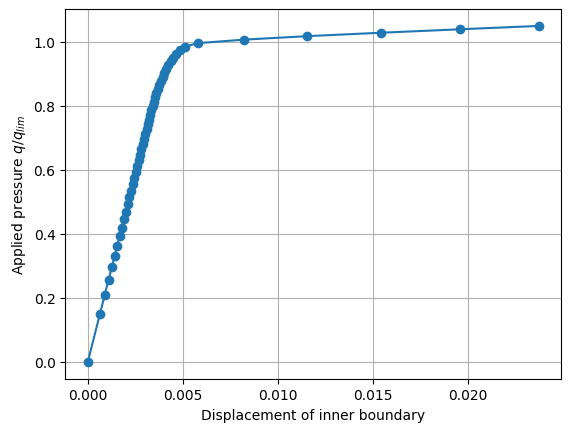

In [18]:
import matplotlib.pyplot as plt
plt.plot(results[:, 0], results[:, 1], "-o")
plt.xlabel("Displacement of inner boundary")
plt.ylabel(r"Applied pressure $q/q_{lim}$")
plt.grid()
plt.show()
